In [1]:
import os
import sys
# module_path = os.path.abspath(os.path.join('../../src'))
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import os
from matplotlib import pyplot as plt

from utils.file import load_from_json
from utils.model import load_lenet, load_pool
from attacks.attack import generate
from utils.metrics import error_rate
from models.athena import Ensemble, ENSEMBLE_STRATEGY


Using TensorFlow backend.
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hezek\.conda\envs\athena\lib\site-packages\t

In [2]:
# global variables
# CONFIG_ROOT = "../../src/configs/"
CONFIG_ROOT = "../src/configs/"

## (Optional) Prepare a smaller dataset for your experiment

* python example: `tutorials/subsamples.py`
* api: `utils.data.subsampling`

In [3]:
from utils.data import subsampling
from utils.file import load_from_json

# load the configurations for the experiment
data_configs = load_from_json("../src/configs/demo/data-mnist.json")
output_root = "../generated"
# print(data_configs.get('bs_file'))


# load the full-sized benign samples
file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
# print('getcwd:      ', os.getcwd())

# print(file)
# print(dir(file))
# print(data_configs.get('dir'))
# print(data_configs.get('label_file'))
X_bs = np.load(file)

# load the corresponding true labels
file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
print(file)
labels = np.load(file)

# get random subsamples
# for MNIST, num_classes is 10
# files "subsamples-mnist-ratio_0.1-xxxxxx.npy" and "sublabels-mnist-ratio_0.1-xxxxxx.npy"
# will be generated and saved at "/results" folder, where "xxxxxx" are timestamps.
subsamples, sublabels = subsampling(data=X_bs,
                                    labels=labels,
                                    num_classes=10,
                                    filepath=output_root,
                                    filename='mnist')

../data/test_Label-mnist-clean.npy


# Generate adversarial examples

We implement the optimization-based attacks, a naive approach by averaging the losses and an approach that extends EOT for ensemble (``Equation (7)`` in the ``ATHENA`` paper).

## Averaging the losses
Extend ``Equation (1)`` for ensemble by averaging the losses of individual WDs in the ensemble.

\begin{equation*}
max_{\delta}\frac{1}{K}\Sigma_{i=1}^{K}\left(\mathcal{L}\left(f_i, \textbf{x}+\delta, y_{true}\right)\right).
\end{equation*}

where $f_i$ is a weak defense in the targeted ensemble.

----
### How to configure the attack
Same as in ``Task 1``.

----
* python example: `tutorials/craft_adversarial_examples.py`
* main api: `attacks.attack.generate`
* check tunable parameters for each attack in file `attacks/attack.py`.

In [7]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs,
                eot=False,
                save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        attack_args = attack_configs.get(key)
        
        attack_args["eot"] = eot
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_args
                            )
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}(EOT:{}): {}->{}'.format(attack_configs.get(key).get("description"),
                                                "ON" if eot else "OFF",
                                                labels[i],
                                                predictions[i]
                                                )
            plt.title(title)
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir, "{}.npy".format(attack_configs.get(key).get("description")))
#             file = os.path.join(output_dir, "{}.npy".format(time.monotonic()))
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

In [ ]:
# loading experiment configurations
trans_configs = load_from_json(CONFIG_ROOT + "demo/athena-mnist.json")
model_configs = load_from_json(CONFIG_ROOT + "demo/model-mnist.json")
data_configs = load_from_json(CONFIG_ROOT + "demo/data-mnist.json")
attack_configs = load_from_json(CONFIG_ROOT + "demo/attack-zk-mnist.json")

# In the context of the white-box threat model,
# we use the ensemble as adversary's target model.
# load weak defenses (in this example, load a tiny pool of 3 weak defenses)
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)
# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

# generate AEs
# in this example, we generate AEs for 5 benign samples
data_bs = data_bs[:5]
labels = labels[:5]

# Normal approach
# Compute the loss w.r.t. a single input
# For an ensemble target, averaging the losses of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(
    model=target, 
    data=data_bs, 
    labels=labels, 
    attack_configs=attack_configs
)

## EOT attack
* paper: [Synthesizing Robust Adversarial Examples](https://arxiv.org/pdf/1707.07397.pdf)
* code GitHub repo: [EOT](https://github.com/prabhant/synthesizing-robust-adversarial-examples)
* ATHENA paper: [ATHENA: A Framework based on Diverse Weak Defenses for Building Adversarial Defense](https://arxiv.org/abs/2001.00308)

We extend ``EOT`` for ensemble in the ``ATHENA`` paper (``Equation (7)``). Currently, we support ``FGSM`` and ``PGD`` as the adversarial optimizer. You will need to provide the configuration for the chosen distribution.

----
### How to configure the distribution
In ``attack-zk-mnist.json``, add a key-value pair: key --- ``"distribution"``; value --- dictionary. configuration for the distribution.

e.g.,
```json
"configs1": {
    "attack": "pgd",
    "description": "PGD_eps0.3",
    "eps": 0.3,
    "distribution": {
      "num_samples": 500,
      "transformation": "translation",
      "min_offset": -0.2,
      "max_offset": 0.2
    }
}

```
where ``num_samples`` is the number of random sampled transformations from the chosen distribution. For detailed explanation, please refer to the ``EOT`` and ``ATHENA`` paper.

Tune the factors to generate AEs variants with various effectiveness:
* parameters of the selected attack method (e.g., ``eps``, ``eps_step``, ``max_iter``, and the like, for ``PGD``).
* distribution settings: ``num_samples``, ``transformation`` and corresponding settings.

----
* python example: `tutorials/craft_adversarial_examples.py`.
* main api: `attacks.attack.generate`.
* check tunable parameters for each attack in file `attacks/attack.py`.
* check tunable parameters for distributions in file `attacks/distribution.py`.

>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loaded 3 models.
>>> Generating FGSM_eps0.07(EOT:ON) examples.
>>> error rate: 0.021


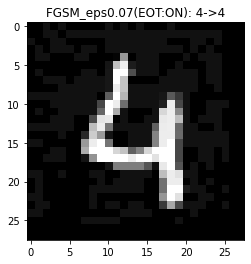

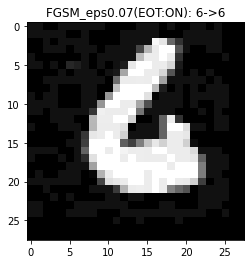

Save the adversarial examples to file [../ae_results\FGSM_eps0.07.npy].
>>> Generating FGSM_eps0.10(EOT:ON) examples.
>>> error rate: 0.029


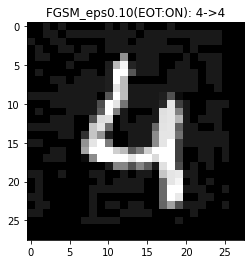

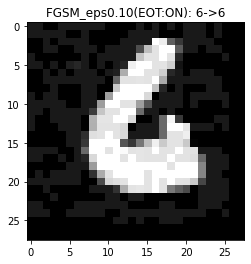

Save the adversarial examples to file [../ae_results\FGSM_eps0.10.npy].
>>> Generating FGSM_eps0.15(EOT:ON) examples.
>>> error rate: 0.052


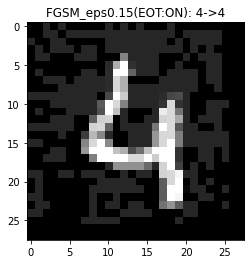

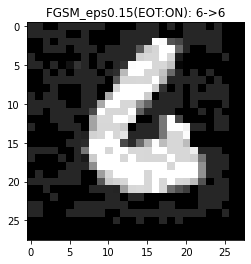

Save the adversarial examples to file [../ae_results\FGSM_eps0.15.npy].
>>> Generating FGSM_eps0.20(EOT:ON) examples.
>>> error rate: 0.112


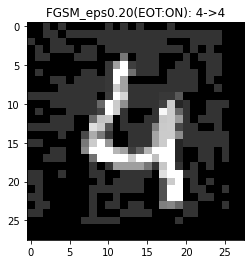

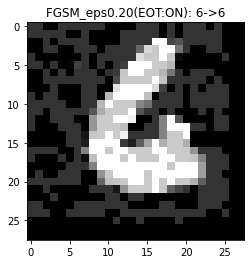

Save the adversarial examples to file [../ae_results\FGSM_eps0.20.npy].
>>> Generating FGSM_eps0.25(EOT:ON) examples.
>>> error rate: 0.241


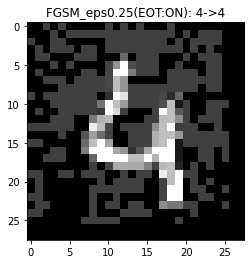

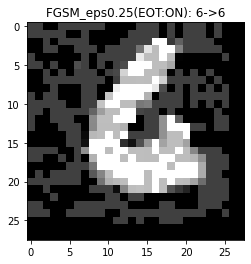

Save the adversarial examples to file [../ae_results\FGSM_eps0.25.npy].
>>> Generating FGSM_eps0.30(EOT:ON) examples.
>>> error rate: 0.415


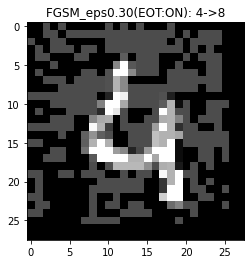

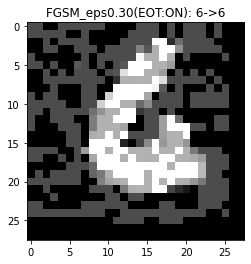

Save the adversarial examples to file [../ae_results\FGSM_eps0.30.npy].
>>> Generating PGD_eps0.07(EOT:ON) examples.
>>> error rate: 0.018


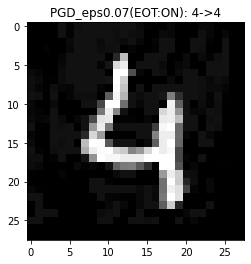

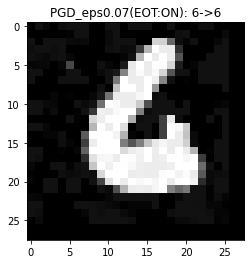

Save the adversarial examples to file [../ae_results\PGD_eps0.07.npy].
>>> Generating PGD_eps0.10(EOT:ON) examples.
>>> error rate: 0.025


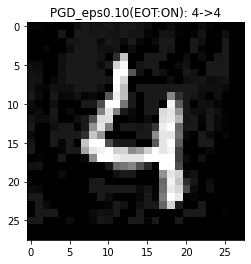

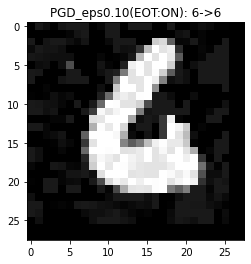

Save the adversarial examples to file [../ae_results\PGD_eps0.10.npy].
>>> Generating PGD_eps0.15(EOT:ON) examples.
>>> error rate: 0.039


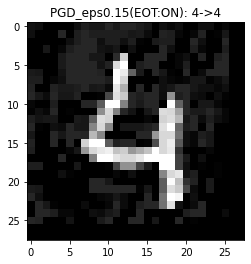

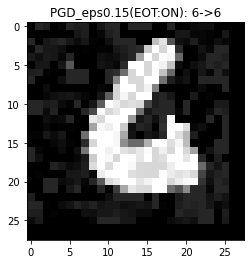

Save the adversarial examples to file [../ae_results\PGD_eps0.15.npy].
>>> Generating PGD_eps0.20(EOT:ON) examples.
>>> error rate: 0.077


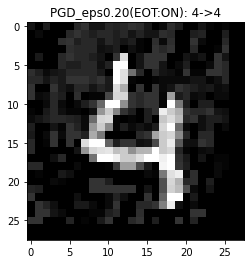

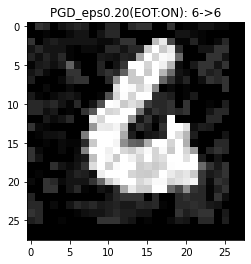

Save the adversarial examples to file [../ae_results\PGD_eps0.20.npy].
>>> Generating PGD_eps0.25(EOT:ON) examples.
>>> error rate: 0.132


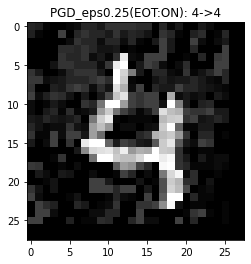

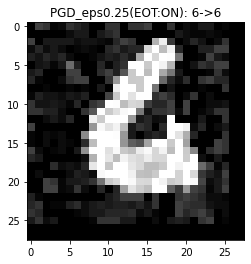

Save the adversarial examples to file [../ae_results\PGD_eps0.25.npy].
>>> Generating PGD_eps0.30(EOT:ON) examples.
>>> error rate: 0.183


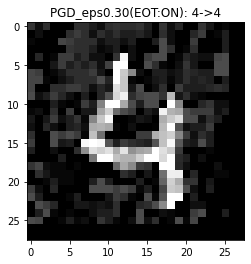

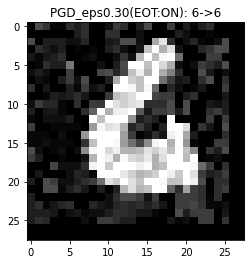

Save the adversarial examples to file [../ae_results\PGD_eps0.30.npy].


In [12]:
# loading experiment configurations
trans_configs = load_from_json(CONFIG_ROOT + "demo/athena-mnist.json")
model_configs = load_from_json(CONFIG_ROOT + "demo/model-mnist.json")
data_configs = load_from_json(CONFIG_ROOT + "demo/data-mnist.json")
attack_configs = load_from_json(CONFIG_ROOT + "demo/attack-zk-mnist.json")

# load weak defenses into a pool
pool, _ = load_pool(trans_configs=trans_configs,
                    model_configs=model_configs,
                    active_list=True,
                    wrap=True)
# create an AVEP ensemble from the WD pool
wds = list(pool.values())
target = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

# load the benign samples
data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

# generate AEs
# in this example, we generate AEs for 5 benign samples
# data_bs = data_bs[:5]
data_bs = data_bs[:]
labels = labels[:]

# Adaptive approach (with EOT)
# Compute the loss expectation over specific distribution.
# For an ensemble target, averaging the EOT of WDs'.
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, eot=True, save=True, attack_configs=attack_configs,output_dir='../ae_results')

## Update the generated adversarial examples in json

* Either add an item for the generated AEs. e.g., assume that we named the generated AE as `"fgsm_eps0.3.npy"`, then add the item as below example, then get your AE list by `data_configs.get("task1_aes")`.

```
"task1_aes" : [
                  "fgsm_eps0.3.npy"
              ]

```


2. Or, create a new json file similar to `"data-mnist.json"`, and replace the whole list for `"ae_files"` with your own list.

# Evaluate the generated AEs
* python example: `tutorials/eval_model.py`
* api: `utils.metrics.error_rate`

In [13]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

def evaluate(trans_configs, model_configs,
             data_configs, task_aes, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    eval_result = {}
    #ae_list = data_configs.get('ae_files')
    ae_list = data_configs.get(task_aes)
    
    for ae in ae_list:
        ae_file = os.path.join(data_configs.get('dir'), ae)
#         print(type(ae_file))
#         print(ae_file)
        #print(ae_list[4])
        x_adv = np.load(ae_file)

        # evaluate the undefended model on the AE
        print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
        pred_adv_um = undefended.predict(x_adv)
        err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['UM'] = err_um
        if 'UM' not in eval_result:
            eval_result['UM'] = [err_um]
        else:
            eval_result['UM'].append(err_um)

        # evaluate the ensemble on the AE
        print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
        pred_adv_ens = ensemble.predict(x_adv)
        err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['Ensemble'] = err_ens
        if 'Ensemble' not in eval_result:
            eval_result['Ensemble'] = [err_ens]
        else:
            eval_result['Ensemble'].append(err_ens)

        # evaluate the baseline on the AE
        print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
        pred_adv_bl = baseline.predict(x_adv)
        err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
        # track the result
        results['PGD-ADT'] = err_bl
        if 'PGD-ADT' not in eval_result:
            eval_result['PGD-ADT'] = [err_bl]
        else:
            eval_result['PGD-ADT'].append(err_bl)

        # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
        print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))
#     task2_eval = eval_result
    return eval_result



In [17]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_root = "../ae_results"

# evaluate task-2 aes
task2_eval = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task2_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
task1_eval = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'task1_aes',
         output_dir=output_root)

# evaluate task-1 aes for comparison
baseline_aes_eval = evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=True, task_aes = 'ae_files',
         output_dir=output_root)

>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keraswrapper.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-shift_bottom_left.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-cartoon_mean_type3.h5]...
>>> Loaded 3 models.
>>> wds: <class 'list'> <class 'models.keraswrapper.WeakDefense'>
>>> Evaluating UM on [../data/subsamples-mnist-ratio_0.1-279895.765.npy], it may take a while...
>>> Evaluating UM on [../data/FGSM_eps0.07_EOT(ON).npy], it may take a while...
>>> Evaluating ensemble on [../data/FGSM_eps0.07_EOT(ON).npy], it may take a while...
>>> Evaluating baseline model on [../data/FGSM_eps0.07_EOT(ON).npy], it may take a while...
>>> Evaluations on [../data/FGSM_eps0.07_EOT(ON).npy]:
{'UM': 0.007077856420626896, 'Ensemble': 0.015166835187057633, 'PGD-ADT': 0.008088978766430738}
>>>

>>> Evaluating ensemble on [../data/PGD_eps0.07.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.07.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.07.npy]:
{'UM': 0.27098078867542974, 'Ensemble': 0.01314459049544995, 'PGD-ADT': 0.015166835187057633}
>>> Evaluating UM on [../data/PGD_eps0.10.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.10.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.10.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.10.npy]:
{'UM': 0.6673407482305359, 'Ensemble': 0.015166835187057633, 'PGD-ADT': 0.01820020222446916}
>>> Evaluating UM on [../data/PGD_eps0.15.npy], it may take a while...
>>> Evaluating ensemble on [../data/PGD_eps0.15.npy], it may take a while...
>>> Evaluating baseline model on [../data/PGD_eps0.15.npy], it may take a while...
>>> Evaluations on [../data/PGD_eps0.15.npy]:
{'UM': 0.9474216380182002, 'Ensemble': 0.028311425682

>>> Evaluations on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.082.npy]:
{'UM': 0.8948432760364005, 'Ensemble': 0.9039433771486349, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.09.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.09.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.09.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.09.npy]:
{'UM': 0.8948432760364005, 'Ensemble': 0.9039433771486349, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.1.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.1.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-bim_ordinf_eps0.1.npy], it may take a while...
>>> Evaluations on [

>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-jsma_theta0.21_gamma0.5.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-jsma_theta0.21_gamma0.5.npy]:
{'UM': 0.9059656218402427, 'Ensemble': 0.9079878665318504, 'PGD-ADT': 0.9029322548028311}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-jsma_theta0.25_gamma0.5.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-jsma_theta0.25_gamma0.5.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-jsma_theta0.25_gamma0.5.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-jsma_theta0.25_gamma0.5.npy]:
{'UM': 0.8928210313447927, 'Ensemble': 0.9059656218402427, 'PGD-ADT': 0.9039433771486349}
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-pgd_eps0.075.npy], it may take a while...


[0.007077856420626896, 0.012133468149646108, 0.019211324570273004, 0.0455005055611729, 0.12740141557128412, 0.34074823053589487]
[0.015166835187057633, 0.023255813953488372, 0.0455005055611729, 0.10414560161779575, 0.23356926188068755, 0.4074823053589484]
[0.008088978766430738, 0.00910010111223458, 0.01314459049544995, 0.017189079878665317, 0.024266936299292215, 0.0455005055611729]
[0.010111223458038422, 0.019211324570273004, 0.032355915065722954, 0.05965621840242669, 0.11627906976744186, 0.2012133468149646]
[0.014155712841253791, 0.020222446916076844, 0.033367037411526794, 0.06875631951466127, 0.12234580384226491, 0.1718907987866532]
[0.010111223458038422, 0.010111223458038422, 0.015166835187057633, 0.023255813953488372, 0.028311425682507583, 0.03538928210313448]
[0.1263902932254803, 0.243680485338726, 0.5005055611729019, 0.717896865520728, 0.8291203235591507, 0.8796764408493428]
[0.019211324570273004, 0.023255813953488372, 0.04954499494438827, 0.12740141557128412, 0.2861476238624874,

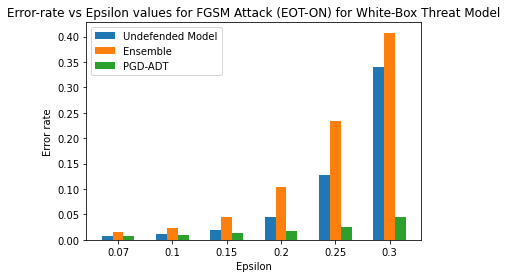

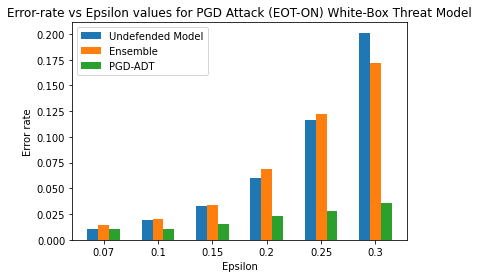

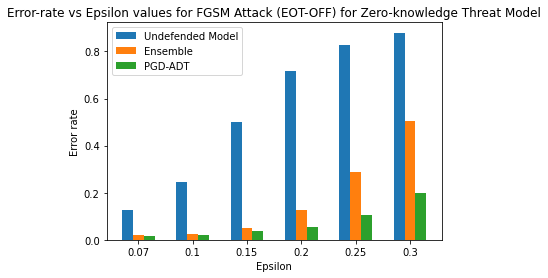

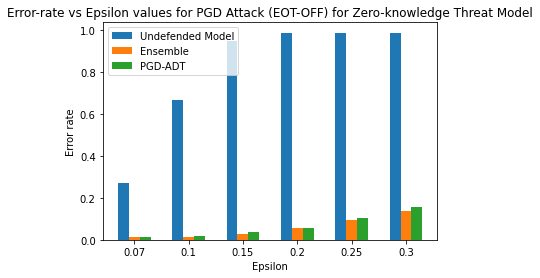

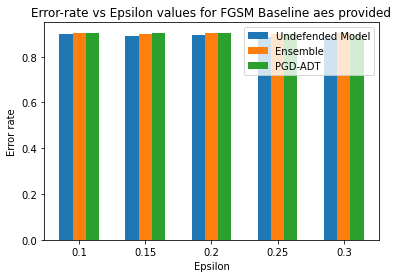

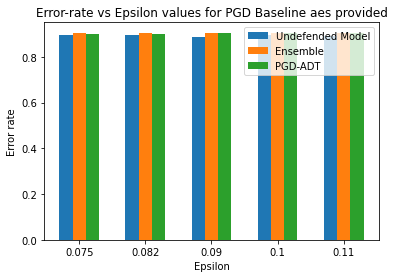

In [18]:
import matplotlib.pyplot as plt
import numpy as np


FGSM_err_task2 = {}
PGD_err_task2 = {}

FGSM_err_task1 = {}
PGD_err_task1 = {}

FGSM_err_baseline = {}
PGD_err_baseline = {}
# BIM_err = {}
#for FGSM_Task 2 aes
FGSM_err_task2['UM'] = task2_eval['UM'][:6]
FGSM_err_task2['Ensemble'] = task2_eval['Ensemble'][:6]
FGSM_err_task2['PGD-ADT'] = task2_eval['PGD-ADT'][:6]
print(FGSM_err_task2['UM'])
print(FGSM_err_task2['Ensemble'])
print(FGSM_err_task2['PGD-ADT'])

# for PGD_Task 2 aes
PGD_err_task2['UM'] = task2_eval['UM'][6:12]
PGD_err_task2['Ensemble'] = task2_eval['Ensemble'][6:12]
PGD_err_task2['PGD-ADT'] = task2_eval['PGD-ADT'][6:12]
print(PGD_err_task2['UM'])
print(PGD_err_task2['Ensemble'])
print(PGD_err_task2['PGD-ADT'])


#for FGSM_Task 1 aes
FGSM_err_task1['UM'] = task1_eval['UM'][:6]
FGSM_err_task1['Ensemble'] = task1_eval['Ensemble'][:6]
FGSM_err_task1['PGD-ADT'] = task1_eval['PGD-ADT'][:6]
print(FGSM_err_task1['UM'])
print(FGSM_err_task1['Ensemble'])
print(FGSM_err_task1['PGD-ADT'])

# for PGD_Task 1 aes
PGD_err_task1['UM'] = task1_eval['UM'][6:12]
PGD_err_task1['Ensemble'] = task1_eval['Ensemble'][6:12]
PGD_err_task1['PGD-ADT'] = task1_eval['PGD-ADT'][6:12]
print(PGD_err_task1['UM'])
print(PGD_err_task1['Ensemble'])
print(PGD_err_task1['PGD-ADT'])

#for FGSM_Baseline examples
FGSM_err_baseline['UM'] = baseline_aes_eval['UM'][:5]
FGSM_err_baseline['Ensemble'] =baseline_aes_eval['Ensemble'][:5]
FGSM_err_baseline['PGD-ADT'] = baseline_aes_eval['PGD-ADT'][:5]
print(FGSM_err_baseline['UM'])
print(FGSM_err_baseline['Ensemble'])
print(FGSM_err_baseline['PGD-ADT'])

# for PGD_Baseline examples
PGD_err_baseline['UM'] = baseline_aes_eval['UM'][30:35]
PGD_err_baseline['Ensemble'] = baseline_aes_eval['Ensemble'][30:35]
PGD_err_baseline['PGD-ADT'] = baseline_aes_eval['PGD-ADT'][30:35]
print(PGD_err_baseline['UM'])
print(PGD_err_baseline['Ensemble'])
print(PGD_err_baseline['PGD-ADT'])


w = 0.2
x = [0.07, 0.10, 0.15, 0.20, 0.25, 0.30] #epsilon values for attack

# FGSM Plot Plots of Error rates in Task 2
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_err_task2['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_err_task2['Ensemble'], w , label='Ensemble')
plt.bar(bar3, FGSM_err_task2['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for FGSM Attack (EOT-ON) for White-Box Threat Model')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

w = 0.2
x = [0.07, 0.10, 0.15, 0.20, 0.25, 0.30]
#For PGD Plot of Error rates in Task 2
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_err_task2['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_err_task2['Ensemble'], w , label='Ensemble')
plt.bar(bar3, PGD_err_task2['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for PGD Attack (EOT-ON) White-Box Threat Model')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

w = 0.2
x = [0.07, 0.10, 0.15, 0.20, 0.25, 0.30]
# FGSM Plot Plots of Error rates in Task 1
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_err_task1['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_err_task1['Ensemble'], w , label='Ensemble')
plt.bar(bar3, FGSM_err_task1['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for FGSM Attack (EOT-OFF) for Zero-knowledge Threat Model')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

#For PGD Plot of Error rates in Task 1
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_err_task1['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_err_task1['Ensemble'], w , label='Ensemble')
plt.bar(bar3, PGD_err_task1['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for PGD Attack (EOT-OFF) for Zero-knowledge Threat Model')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()


w = 0.2
x = [0.10, 0.15, 0.20, 0.25, 0.30] #epsilon values for attack

# FGSM Plot Plots of Error rates in Baseline aes
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, FGSM_err_baseline['UM'], w , label='Undefended Model')
plt.bar(bar2, FGSM_err_baseline['Ensemble'], w , label='Ensemble')
plt.bar(bar3, FGSM_err_baseline['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for FGSM Baseline aes provided')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

w = 0.2
x = [0.075, 0.082, 0.09, 0.10, 0.11]
#For PGD Plot of Error rates in baseline aes
bar1 = np.arange(len(x))
bar2 = [i+w for i in bar1]
bar3 = [i+2*w for i in bar1]
plt.bar(bar1, PGD_err_baseline['UM'], w , label='Undefended Model')
plt.bar(bar2, PGD_err_baseline['Ensemble'], w , label='Ensemble')
plt.bar(bar3, PGD_err_baseline['PGD-ADT'], w , label='PGD-ADT')

plt.xlabel('Epsilon')
plt.ylabel('Error rate')
plt.title('Error-rate vs Epsilon values for PGD Baseline aes provided')
plt.xticks(bar1+w, x)
plt.legend()
plt.show()

# #For BIM Plot of Error rates
# bar1 = np.arange(len(x))
# bar2 = [i+w for i in bar1]
# bar3 = [i+2*w for i in bar1]
# plt.bar(bar1, BIM_err['UM'], w , label='Undefended Model')
# plt.bar(bar2, BIM_err['Ensemble'], w , label='Ensemble')
# plt.bar(bar3, BIM_err['PGD-ADT'], w , label='PGD-ADT')

# plt.xlabel('Epsilon')
# plt.ylabel('Error rate')
# plt.title('Error-rate vs Epsilon values for BIM Attack')
# plt.xticks(bar1+w, x)
# plt.legend()
# plt.show()

# Group Name: Team Horus
Group Members (Git-hub Usernames):
1. Withana (Rasika) Jayarathna (Rasika-prog)
2. Kaveh Shariati (kavehshariati)
3. Joshua Ojih (ojihjo)
4. Olajide Bamidele (42n8dzydoo)

## Attacks Used and Config Settings: 
FGSM and PGD with EOT (switched ON) The following instances of epsilon settings were used to generate Adversarial Examples for the three types of attacks done (listed above): 0.07, 0.10, 0.15, 0.20, 0.25, 0.30

## The EOT attack
* paper: [Synthesizing Robust Adversarial Examples](https://arxiv.org/pdf/1707.07397.pdf)
* code GitHub repo: [EOT](https://github.com/prabhant/synthesizing-robust-adversarial-examples)
* ATHENA paper: [ATHENA: A Framework based on Diverse Weak Defenses for Building Adversarial Defense](https://arxiv.org/abs/2001.00308)

As suggested in the ``ATHENA`` paper (``Equation (7)``), we applied the ``EOT`` for ensemble on the Adversarial Examples generated using the FGSM and PGD attacks. The configuration of the parameters tuned for chosen distribution is given below.


----
### Configuration of the distribution
In ``attack-zk-mnist.json``, the key-value pair: key --- ``"distribution"``; value --- dictionary. configuration for the distribution was tuned.

For the FGSM Attack (for all values of epsilon), the distribution was tuned as:
```json
"configs1": {
    "attack": "FGSM",
    "description": "FGSM_eps0.3",
    "eps": 0.3,
    "distribution": {
      "num_samples": 1000,
      "transformation": "rotation",
      "min_angle": -45,
      "max_angle": 45
    }
}

```

For the PGD Attack (for all values of epsilon), the distribution was tuned as:
```json
"configs1": {
    "attack": "pgd",
    "description": "PGD_eps0.3",
    "eps": 0.3,
   "distribution": {
      "num_samples": 500,
      "transformation": "gaussian_noise",
      "eta": 0.03,
      "clip_min": 0.0,
      "clip_max": 1.0
    }
}

```
where ``num_samples`` is the number of random sampled transformations from the chosen distribution. For detailed explanation, please refer to the ``EOT`` and ``ATHENA`` paper.

Tune the factors to generate AEs variants with various effectiveness:
* parameters of the selected attack method (e.g., ``eps``, ``eps_step``, ``max_iter``, and the like, for ``PGD``).
* distribution settings: ``num_samples``, ``transformation`` and corresponding settings.

Additionally, default settings of Epsilon step (eps_step) of (0.1* epsilon) and maximum iteration of 100 were used to generate the PGD Adversarial Examples

## Analysis of Results
The 12 Adversarial Examples (AEs) generated were tested on the Athena model using the AVEP Ensemble strategy and the results were plotted above.

# Observations

1. In the zero-knowledge threat model for PGD attack, defense by athena is better than state-of-the-art defense by PGD-ADT for all values of epsilon.  


2. In the zero-knowledge threat model for FGSM attack, state-of-the-art defense by PGD-ADT is better than  defense by athena for all values of epsilon.


3. In the white box threat model, the adversary knows everything about the model (target classifier, existense of defense, weak defenses and ensemble strategy). For all cases the adversrary assumes there is a defense in place called athena. Hence, the defense by athena is worse than the undefended model for both the FGSM and PGD, except for one case in which PGD with epsilon 0.3. Furthermore, the defense by the state-of-the-art defense by PGD-ADT is much better for all cases since the adversary's attack is based on athena.


4. When evaluated by using the provided baseline adversarial examples the error rate was very high (around 0.9) for undefended, athena defense and the PGD-ADT defense for all the values of epsilon. It seems that the adversary is an advanced form of white box attack which knows everything about the athena defense and the PGD-ADT defense.

# Citations

## EOT Ensemble
* paper: [Synthesizing Robust Adversarial Examples](https://arxiv.org/pdf/1707.07397.pdf)
* code GitHub repo: [EOT](https://github.com/prabhant/synthesizing-robust-adversarial-examples)
* ATHENA paper: [ATHENA: A Framework based on Diverse Weak Defenses for Building Adversarial Defense](https://arxiv.org/abs/2001.00308)

## Athena Framework
* ATHENA paper: [ATHENA: A Framework based on Diverse Weak Defenses for Building Adversarial Defense](https://arxiv.org/abs/2001.00308)
* code GitHub repo: [EOT](https://github.com/csce585-mlsystems/project-athena)